# **Task**

**ARIMA Models (Core)**

    * Load this [Walmart stock data](https://www.kaggle.com/datasets/meetnagadia/walmart-stock-price-from-19722022). [(source)](https://www.kaggle.com/datasets/meetnagadia/walmart-stock-price-from-19722022)
    
    * We will use data from 2010 to 2020 to predict the  Adjusted Close values for the next quarter.
    
    * Make a datetime index using the Date column with a business day frequency ('B')
    
    * Check for and address null values.
    
    * Check the time series for stationarity
        * Determine the number of differencing (d) needed to make the data stationary. (We recommend using pmdarima's ndiffs)
    
    * Use ACF/PACF plots of the stationary data to estimate initial time series model orders (p,d,q)
    
    * Split the time series into training and test data. Use a test_size of one quarter (13 weeks X 5 business days)
    
    * Fit an ARIMA model based on the orders determined during your exploration.
        * Make forecasts with your model.
        * Plot the forecasts versus the test data.
        * Obtain metrics for evaluation.
    
    * Try at least one variation of the model for comparison (we recommend using a loop to try combinations of model orders)
    
    * A MAPE of less than 2% on the test data is achievable.
    
    * Choose a final model and explain:
        * How good was your model, according to your Mean Absolute Percentage Error?
        * How good was your model in terms of how well the forecast seems to follow the test data, visually?  (Hint: You may want to plot fewer training data lags to see this)

# **Solution**

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import set_config

from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs

import statsmodels.tsa.api as tsa

In [2]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [3]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)
    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)
    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")
        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 
        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")
    fig.tight_layout()
    
    return fig

In [4]:
# set_config(transform_output="pandas")
# plt.rcParams["figure.figsize"] = (12, 4)
# sns.set_context("talk", font_scale=0.9)

In [5]:
def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False) 
    r_squared = r2_score(y_true, y_pred)
    if verbose == True:
        # Print Result with Label and Header
        header = "-"*60
        print(header, f"Regression Metrics: {label}", header, sep='\n')
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
    if output_dict == True:
        metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
        return metrics

def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
    # Get predictions for training data
    y_train_pred = reg.predict(X_train)

    # Call the helper function to obtain regression metrics for training data
    results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
    print()
    # Get predictions for test data
    y_test_pred = reg.predict(X_test)
    # Call the helper function to obtain regression metrics for test data
    results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )

    # Store results in a dataframe if ouput_frame is True
    if output_frame:
        results_df = pd.DataFrame([results_train,results_test])
        # Set the label as the index 
        results_df = results_df.set_index('Label')
        # Set index.name to none to get a cleaner looking result
        results_df.index.name=None
        # Return the dataframe
        return results_df.round(3)

In [6]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [8]:
# Import/ Load data
df = pd.read_csv('Data/WMT.csv')
df.head()

,Date,Adj Close
0,2000-01-03,44.915394
1,2000-01-04,43.234756
2,2000-01-05,42.352402
3,2000-01-06,42.814564
4,2000-01-07,46.049828


In [9]:
# Explore the data
df['Date'].value_counts()

2000-01-03    1
2013-12-30    1
2014-01-09    1
2014-01-08    1
2014-01-07    1
             ..
2007-01-01    1
2006-12-29    1
2006-12-28    1
2006-12-27    1
2020-12-31    1
Name: Date, Length: 5479, dtype: int64

In [10]:
    # * We will use data from 2010 to 2020 to predict the Adjusted Close values for the next quarter.
    # * Make a datetime index using the Date column with a business day frequency ('B')

In [11]:
# cast date as date time, set index, set freq, check nulls
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [12]:
df = df.set_index('Date')
df

,Adj Close
Date,
2000-01-03,44.915394
2000-01-04,43.234756
2000-01-05,42.352402
2000-01-06,42.814564
2000-01-07,46.049828
...,...
2020-12-25,NaN
2020-12-28,142.946777
2020-12-29,142.041183


In [13]:
df.asfreq('B')

,Adj Close
Date,
2000-01-03,44.915394
2000-01-04,43.234756
2000-01-05,42.352402
2000-01-06,42.814564
2000-01-07,46.049828
...,...
2020-12-25,NaN
2020-12-28,142.946777
2020-12-29,142.041183


In [14]:
df.isna().sum()

Adj Close    195
dtype: int64

In [15]:
# Address null values
df['Adj Close'] = df['Adj Close'].interpolate()

In [16]:
df.isna().sum()

Adj Close    0
dtype: int64

In [17]:
#     * We will use data from 2010 to 2020 to predict the Adjusted Close values for the next quarter.
df_ts = df.loc['2010':'2020',['Adj Close']]
df_ts

,Adj Close
Date,
2010-01-01,40.669043
2010-01-04,40.963638
2010-01-05,40.555729
2010-01-06,40.465084
2010-01-07,40.487759
...,...
2020-12-25,142.100257
2020-12-28,142.946777
2020-12-29,142.041183


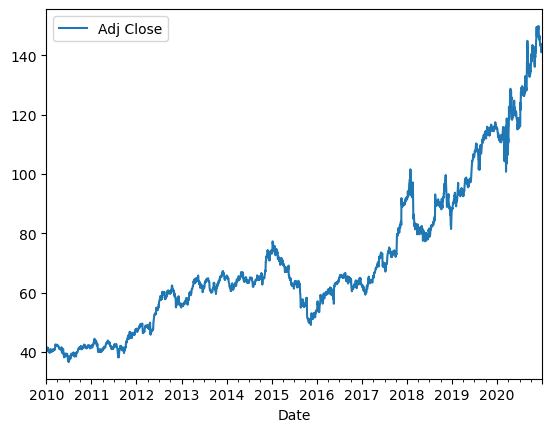

In [18]:
# Plot raw data
df_ts.plot();

In [19]:
# Not stationary

In [20]:
#     * Check the time series for stationarity
#        * Determine the number of differencing (d) needed to make the data stationary. (We recommend using pmdarima's ndiffs)
# use get_adfuller_results
get_adfuller_results(df_ts)

# lags gaps in x-y axis
# Not stationary

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,1.470646,23,2846,0.997413,0.05,False


In [21]:
# use get_adfuller_results
df_ts_diff = df_ts.diff().dropna()
get_adfuller_results(df_ts.diff().dropna())

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-12.219253,22,2846,0.0,0.05,True


In [22]:
# use ndiffs (number of difference)
ndiffs(df_ts)

# The value of ndiffs suggests the order = 1 means that the series is more stationary than the original state

1

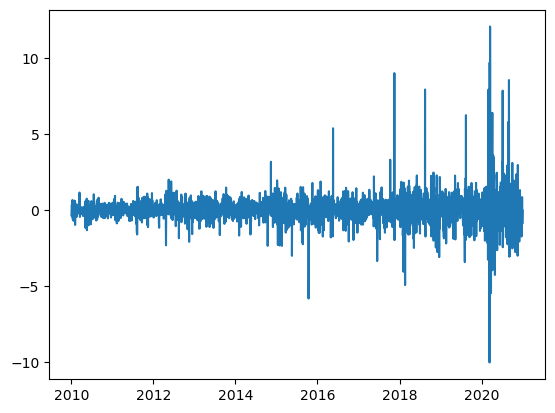

In [23]:
# plot differenced data (ACF autocorrelation PACF partial autocorrelation function)
plt.plot(df_ts.diff());

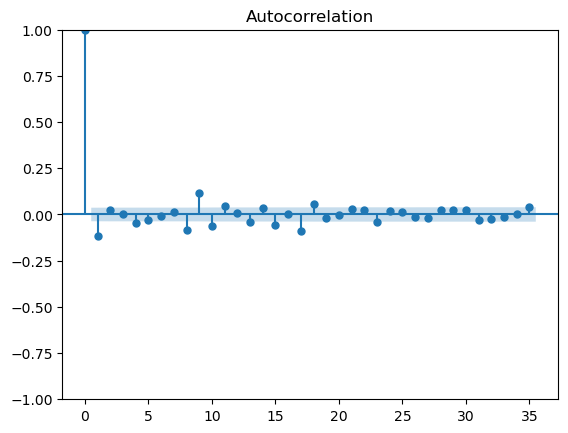

In [24]:
# plot ACF
tsa.graphics.plot_acf(df_ts.diff().dropna());

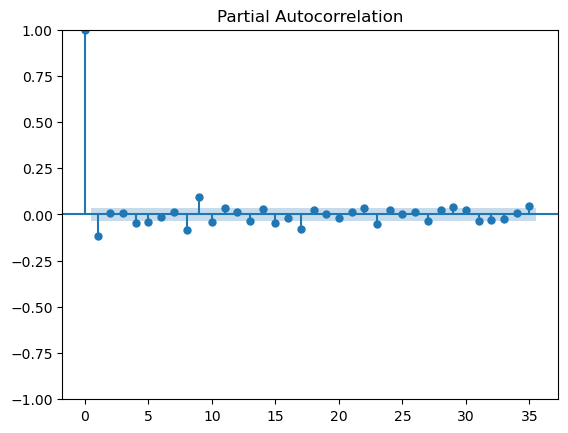

In [25]:
## plot PACF
tsa.graphics.plot_pacf(df_ts.diff().dropna(), method='ywm');

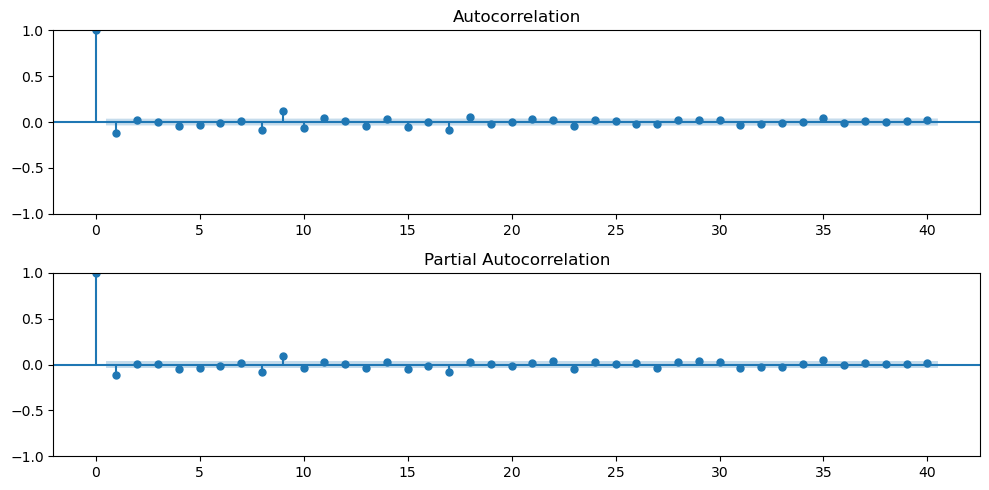

In [26]:
# Use differenced (stationary) data to plot together ACF and PACF to compare
plot_acf_pacf(df_ts_diff);

In [27]:
# Modeling

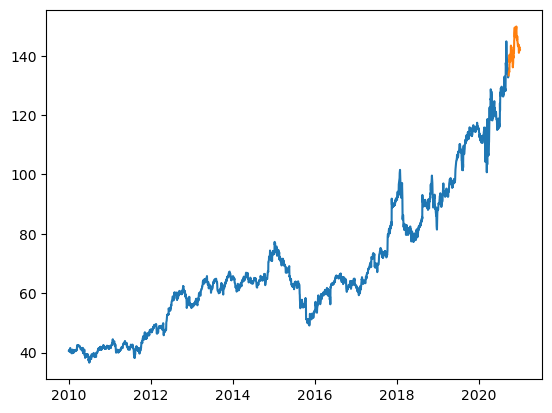

In [28]:
# train-test split
train, test = train_test_split(df_ts, test_size = .025) # Test size of one quarter (13 weeks x 5 business days)
# 13 weeks , 5 business days with 4 quarters in a year for 10 years, test size is 13 weeks x 5 business days = 65 business days in 1 quarter) 

# plot train and test
plt.plot(train)
plt.plot(test);

In [29]:
# Fit the ARIMA Model
# First define the orders (p,d,q)
p = 1
d = 1
q = 1

# Now instantiate the model with the data and fit
arima_model = tsa.ARIMA(train, order = (p, q, d)).fit()
arima_model

C:\Users\ASUS TUF\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\ASUS TUF\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\ASUS TUF\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


In [30]:
# import libraries
import warnings
from statsmodels.tsa.arima.model import ARIMA

# suppress all warnings
warnings.filterwarnings('ignore')

# fit the model
arima_model = ARIMA(train, order = (p, d, q)).fit()

In [31]:
# Evaluate the ARIMA model
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2798
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3818.450
Date:                Sat, 06 Apr 2024   AIC                           7642.900
Time:                        22:12:51   BIC                           7660.709
Sample:                    01-01-2010   HQIC                          7649.329
                         - 09-22-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2552      0.048     -5.323      0.000      -0.349      -0.161
ma.L1          0.1434      0.051      2.836      0.005       0.044       0.242
sigma2         0.8981      0.006    142.959      0.000       0.886       0.910
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            106497.84
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):              10.22   Skew:                             1.29
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

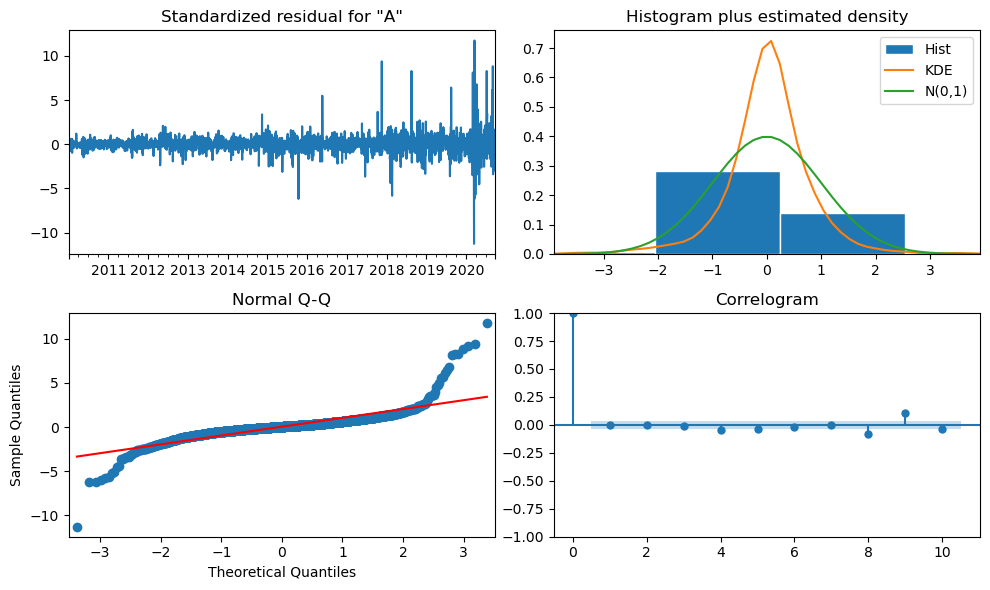

In [32]:
# Obtain diagnostic plots
fig = arima_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 7.001
- MSE = 63.563
- RMSE = 7.973
- R^2 = -2.717
- MAPE = 4.84%


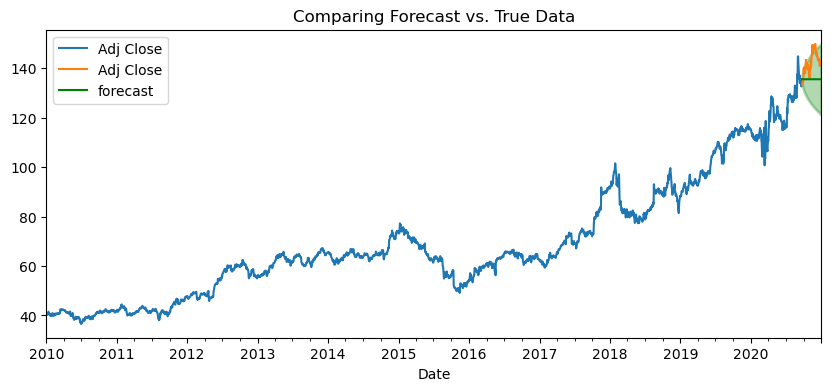

In [33]:
# Obtain summary of forecast as dataframe
forecast_df = arima_model.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

In [34]:
# legend = blue is train, orange is test

In [35]:
# use model.get_forecast()
preds_df = arima_model.get_forecast(steps = len(test)).summary_frame()

In [36]:
# Check forecast by plotting and calculating evaluation metrics

# Additional custom functions

In [37]:
# Loop through variations of model and consider alternatives

In [38]:
import itertools

# Define the value or range of values for p, d, q
p_values = range(0, 2)  
d_values = [1]          
q_values = range(0, 2)  

# Create combinations of pdq to test
pdq_to_try = list(itertools.product(p_values, d_values, q_values))
                                            
pdq_to_try

[(0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1)]

In [39]:
# define starting aic as infinity
best_aic = float("inf")  

# define baseline for pdq
best_pdq = (0,0,0)

# Loop through each combination
for pdq in pdq_to_try:
    
    model = tsa.ARIMA(train, order=pdq)
                              
    result = model.fit()
    
    print(pdq, result.aic)      
    
    # If lower, replace best AIC with new value
    if result.aic < best_aic:
        
        best_aic = result.aic
        best_pdq = pdq
        
# Print the best orders and AIC score
print("Best AIC:", best_aic)
print("Best pdq:", best_pdq)

(0, 1, 0) 7676.056796792222
(0, 1, 1) 7643.407844641544
(1, 1, 0) 7641.789504342757
(1, 1, 1) 7642.899840630123
Best AIC: 7641.789504342757
Best pdq: (1, 1, 0)


In [40]:
# Fit the ARIMA Model
# First define the orders (p,d,q) using best pdq
p = 1
d = 1
q = 0

# Now instantiate the model with the data and fit
arima_model = tsa.ARIMA(train, order = (p, q, d)).fit()
arima_model

In [41]:
# import libraries
import warnings
from statsmodels.tsa.arima.model import ARIMA

# suppress all warnings
warnings.filterwarnings('ignore')

# fit the model
arima_model = ARIMA(train, order = (p, d, q)).fit()

In [42]:
# Evaluate the ARIMA model using best pdq
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2798
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -3818.895
Date:                Sat, 06 Apr 2024   AIC                           7641.790
Time:                        22:12:55   BIC                           7653.662
Sample:                    01-01-2010   HQIC                          7646.075
                         - 09-22-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1135      0.005    -20.717      0.000      -0.124      -0.103
sigma2         0.8984      0.006    144.562      0.000       0.886       0.911
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            108427.17
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):              10.23   Skew:                             1.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

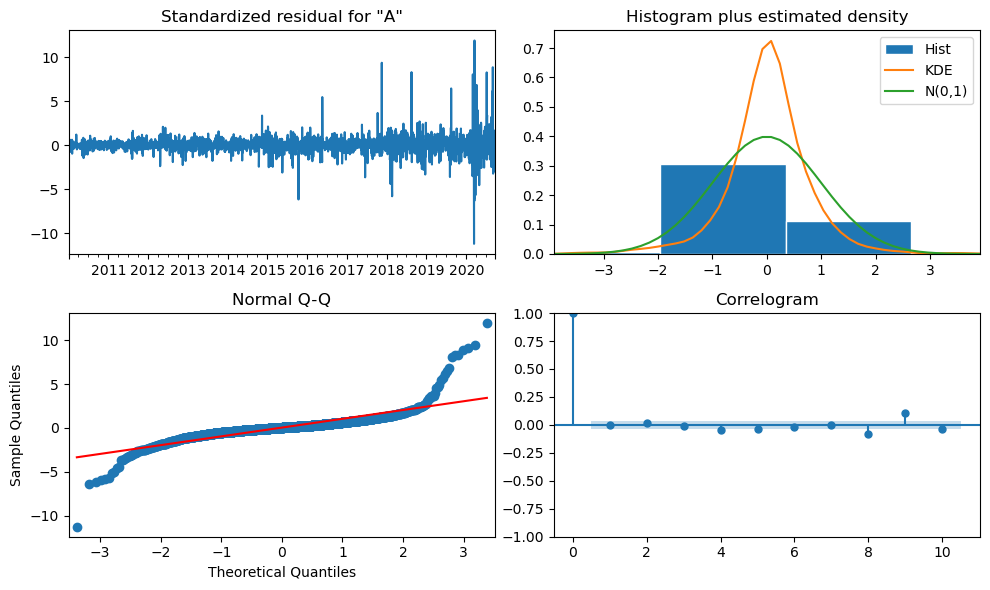

In [43]:
# Obtain diagnostic plots
fig = arima_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 7.036
- MSE = 64.118
- RMSE = 8.007
- R^2 = -2.749
- MAPE = 4.87%


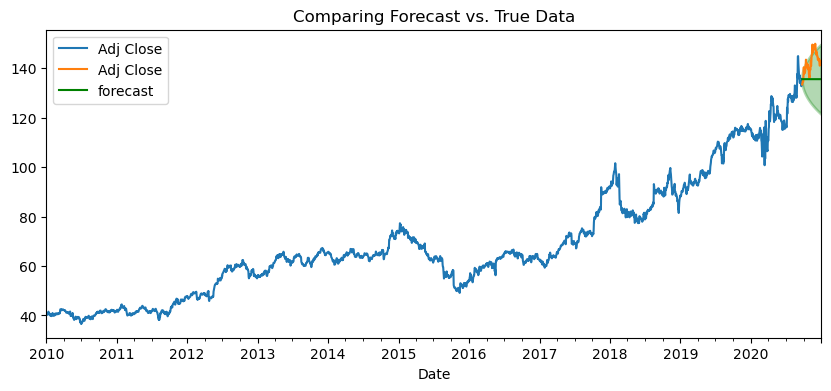

In [44]:
# Obtain summary of forecast as dataframe
forecast_df = arima_model.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

In [45]:
# legend = blue is train, orange is test

* A MAPE of less than 2% on the test data is achievable.

* Choose a final model and explain:
    * How good was your model, according to your Mean Absolute Percentage Error? MAPE seems slightly better in the original ARIMA model (1,1,1) at 4.84% versus the last one using pdq (1,1,0) at MAPE 4.87%. But AIC and BIC are lower for the final model too. Given how iterations where done to check the best, I guess it is safe to choose the final model
    * How good was your model in terms of how well the forecast seems to follow the test data, visually?  (Hint: You may want to plot fewer training data lags to see this) The model does not perfectly follow the test data, visually. The "upper" boundaries do though.